## imports

In [1]:
# pip install plotly.express

In [20]:
import pandas as pd
import numpy as np
from itables import show
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# Data description

This dataset offers a variety of attributes valuable for comprehensive analysis. It contains 555,719 instances and 22 attributes, a mix of categorical and numerical data types. Importantly, the dataset is complete with no null values. Here's a breakdown of the attributes:

- Trans_date_trans_time: Timestamp of the transaction (date and time).
- Cc_num:Unique customer identification number.
- Merchant - The merchant involved in the transaction.
- Category Transaction type (e.g., personal, childcare).
- Amt:Transaction amount.
- First: Cardholder's first name.
- Last Cardholder's last name.
- Gender: Cardholder's gender.
- Street: Cardholder's street address.
- City: Cardholder's city of residence.
- State: Cardholder's state of residence.
- Zip: Cardholder's zip code.
- Lat:Latitude of cardholder's location.
- Long: Longitude of cardholder's location.
- City_pop:Population of the cardholder's city.
- Job:Cardholder's job title.
- Dob: Cardholder's date of birth.
- Trans_num: Unique transaction identifier.
- Unix_time: Transaction timestamp (Unix format).
- Merch_lat:Merchant's location (latitude).
- Merch_long: Merchant's location (longitude).
- Is_fraud:Fraudulent transaction indicator (1 = fraud, 0 = legitimate). This is the target variable for classification purposes.


In [ ]:
# Klara
df_fraud = pd.read_csv('C:/Users/halou/Documents/master uni_vie/Doing DS/project/fraud_test.csv')

show(df_fraud.head())
print(df_fraud.info())
print(df_fraud.describe())

print("================================")
print(f"Missing values in the whole data set: {((df_fraud.isnull().sum()).sum())}")

Loading ITables v2.5.2 from the internet... (need help?)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

# Data manipulation
- time: split into hours and days of the week
- 904 customers in total
- no NaNs (yay)

## questions encountered
- is it possible one card had two cardholders?
- do we create age groups? if so, how?
- is it more explanatory to plot fraud rate or total amount of fraud commited?

In [16]:
print(df_fraud['merchant'].str.contains('fraud_').sum())
print("===================================")

# Group by cc_num and count unique customer names
violations = df_fraud.groupby('cc_num')['last'].nunique()

# Show cards with multiple names
problem_cards = violations[violations > 1]
print(f"Cards with multiple names: {len(problem_cards)}")
print(problem_cards)

555719
Cards with multiple names: 19
cc_num
3.051820e+13    2
1.800470e+14    3
1.800650e+14    2
1.800680e+14    2
1.800850e+14    2
2.131130e+14    2
2.131610e+14    2
2.131740e+14    2
2.131790e+14    2
2.131870e+14    2
3.712840e+14    2
3.506040e+15    2
3.529600e+15    2
4.302480e+15    2
6.011150e+15    2
6.011370e+15    2
6.011380e+15    2
6.011390e+15    2
6.011680e+15    2
Name: last, dtype: int64


In [19]:
# rename variables
df_fraud.rename(columns={"Unnamed: 0": "id"}, inplace=True)
df_fraud["merchant"] = df_fraud["merchant"].str.replace("fraud_", "")
df_fraud[["trans_date", "trans_time"]] = df_fraud["trans_date_trans_time"].str.split(" ", expand=True)

# drop trans_date_trans_time column
df = df_fraud.copy()
df_fraud = df_fraud.drop(columns="trans_date_trans_time")

show(df_fraud.head())

Loading ITables v2.5.2 from the internet... (need help?)


In [26]:
print(f"Date range: {df_fraud['trans_date'].min().date()} to {df_fraud['trans_date'].max().date()}")

Date range: 2020-06-21 to 2020-12-31


In [27]:
# convert to date 
df_fraud["trans_date"] = pd.to_datetime(df_fraud["trans_date"])
df_fraud["trans_time"] = pd.to_datetime(df_fraud["trans_time"], format="%H:%M:%S").dt.time
df_fraud["trans_time_group"] = pd.to_datetime(df_fraud["trans_time"], format="%H:%M:%S").dt.hour
df_fraud["trans_month"] = df_fraud["trans_date"].dt.to_period("M").astype("str")
df_fraud["trans_dayOfWeek"] = df_fraud["trans_date"].dt.day_name()

# calculate age
df_fraud["dob"] = pd.to_datetime(df_fraud["dob"])
df_fraud["age"] = (2020 - df_fraud["dob"].dt.year) # all transactions happened in 2020

show(df_fraud.head())

Loading ITables v2.5.2 from the internet... (need help?)


## Exploratory Data Analysis (EDA)

In [4]:
total = len(df_fraud)
fraud_count = (df_fraud['is_fraud']==1).sum()

print(f"Unique credit cards: {df_fraud['cc_num'].nunique():,}")
print(f"Unique merchants: {df_fraud['merchant'].nunique():,}")
print(f"Fraudulent transactions: {fraud_count:,} ({fraud_count/total*100:.2f}%)")

Unique credit cards: 904
Unique merchants: 693
Fraudulent transactions: 2,145 (0.39%)


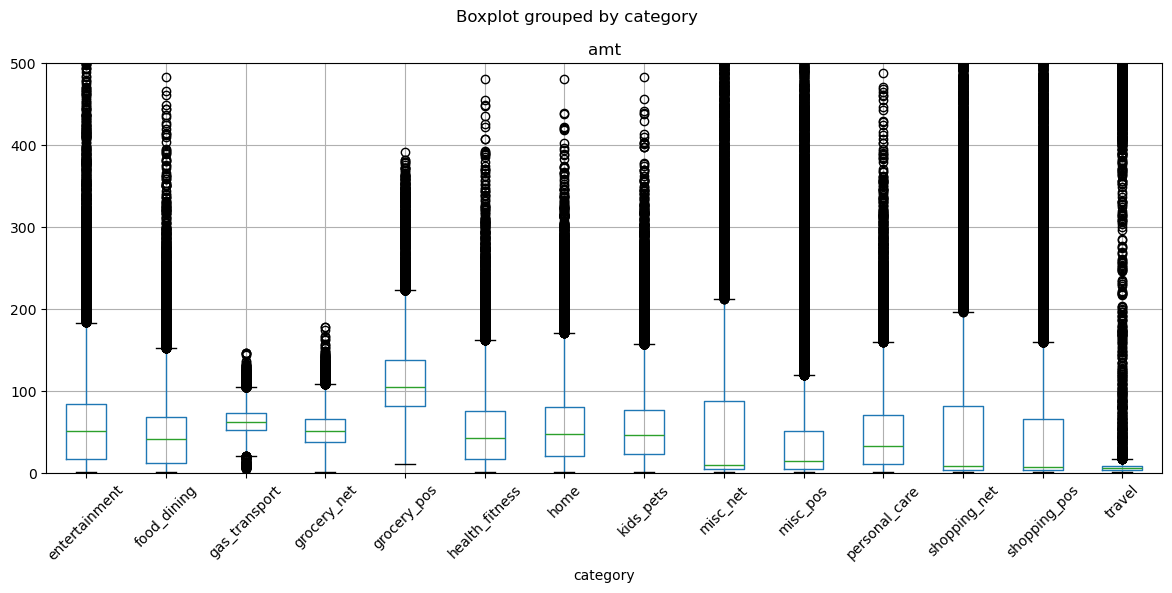

In [5]:
# view counts of merchants (if wanted)
# print(df_fraud['merchant'].value_counts(normalize=False))

df_fraud.boxplot(column='amt', by='category', figsize=(12, 6))
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 500)  # Set y-axis from 0 to 500
plt.show()

In [21]:
print("number of unique merchants:", df_fraud['merchant'].nunique())
print("=====================================================")

# Count unique lat/long pairs per merchant
location_check = df_fraud.groupby('merchant')[['merch_lat', 'merch_long']].nunique()

# Find merchants with multiple locations
multiple_locations = location_check[(location_check['merch_lat'] > 1) | (location_check['merch_long'] > 1)]

print(f"Merchants with multiple locations: {len(multiple_locations)}")
print("=====================================================")
print(multiple_locations)

# CHECK WEIRD BEHAVIOR
# Pick one merchant and see its actual coordinates
merchant = 'fraud_Abbott-Rogahn'
locations = df_fraud[df_fraud['merchant'] == merchant][['merchant', 'merch_lat', 'merch_long']].drop_duplicates()
print(f"Number of locations: {len(locations)}")
print("=====================================================")
print(locations.head(10))

number of unique merchants: 693
Merchants with multiple locations: 693
                                  merch_lat  merch_long
merchant                                               
fraud_Abbott-Rogahn                     803         803
fraud_Abbott-Steuber                    766         766
fraud_Abernathy and Sons                762         762
fraud_Abshire PLC                       838         838
fraud_Adams, Kovacek and Kuhlman        414         414
...                                     ...         ...
fraud_Zemlak Group                      591         591
fraud_Zemlak, Tillman and Cremin        734         734
fraud_Ziemann-Waters                    743         743
fraud_Zieme, Bode and Dooley           1160        1160
fraud_Zulauf LLC                        822         822

[693 rows x 2 columns]
Number of locations: 803
                  merchant  merch_lat  merch_long
940    fraud_Abbott-Rogahn  31.241331  -84.380598
4363   fraud_Abbott-Rogahn  33.070647  -82.074740
44

In [6]:
df_fraud["Merch_lat_round"] = df_fraud["merch_lat"].round(4)
df_fraud["Merch_long_round"] = df_fraud["merch_long"].round(4)

df_fraud["merchant_location"] = list(zip(df_fraud["Merch_lat_round"], df_fraud["Merch_long_round"]))
merchant_locations = (
    df_fraud.groupby("merchant")["merchant_location"]
      .nunique()
      .reset_index(name="n_locations")
)

single_location = merchant_locations[merchant_locations["n_locations"] == 1]
multi_location  = merchant_locations[merchant_locations["n_locations"] > 1]

print(f"Number of stores with just one location: {len(single_location)}")
print(f"Number of stores with multiple locations: {len(multi_location)}")


Number of stores with just one location: 0
Number of stores with multiple locations: 693


In [34]:
avg_amt.values[1, 1]

np.float64(528.3564941724942)

C:\Users\halou\AppData\Local\Temp\ipykernel_39860\978211228.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Not Fraud','Fraud'], rotation = 0)


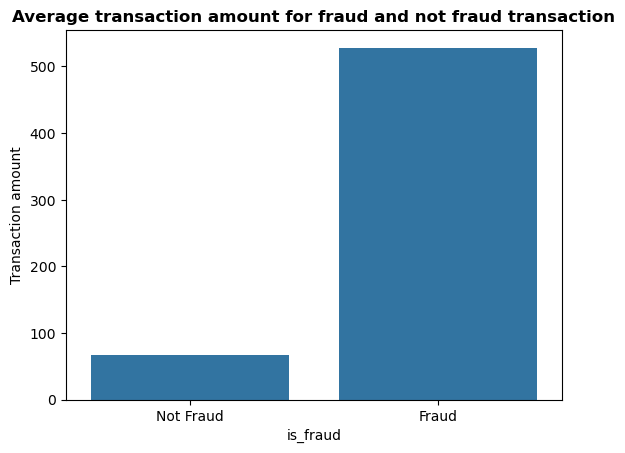

Average fraudulent amount: 67.61, average non-fraudulent amount: 528.36


In [ ]:
# average transaction amount for fraudulent and non-fraudulent transactions
avg_amt = df.groupby('is_fraud')['amt'].mean().reset_index()
ax = sns.barplot(data = avg_amt, x = 'is_fraud', y='amt')
plt.title('Average transaction amount for fraud and not fraud transaction',fontsize=12,fontweight='bold')
plt.ylabel("Transaction amount")
ax.set_xticklabels(['Not Fraud','Fraud'], rotation = 0)
plt.show()

print(f"Average non-fraudulent amount: {avg_amt.values[0, 1]:.2f}, average fraudulent amount: {avg_amt.values[1,1]:.2f}")

### Transactions on map

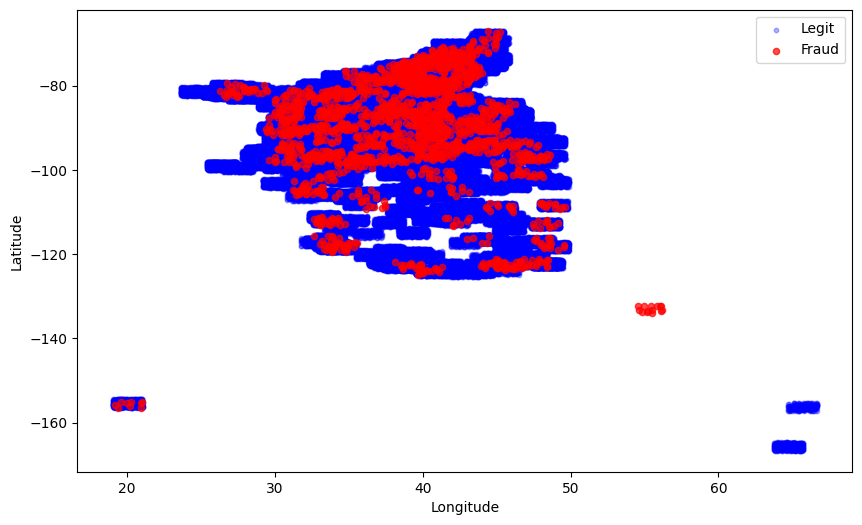

In [ ]:
# plot transactions on map
plt.figure(figsize=(10, 6))
plt.scatter(df_fraud[df_fraud['is_fraud']==0]['merch_lat'], df_fraud[df_fraud['is_fraud']==0]['merch_long'], 
            alpha=0.3, s=10, c='blue', label='Legit')
plt.scatter(df_fraud[df_fraud['is_fraud']==1]['merch_lat'], df_fraud[df_fraud['is_fraud']==1]['merch_long'], 
            alpha=0.7, s=20, c='red', label='Fraud')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [12]:
"""fig = px.scatter_mapbox(df_fraud, lat='merch_lat', lon='merch_long', color='is_fraud',
                        zoom=3, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.show()"""

'fig = px.scatter_mapbox(df_fraud, lat=\'merch_lat\', lon=\'merch_long\', color=\'is_fraud\',\n                        zoom=3, height=600)\nfig.update_layout(mapbox_style="open-street-map")\nfig.show()'

### Frauds by hour, day and month

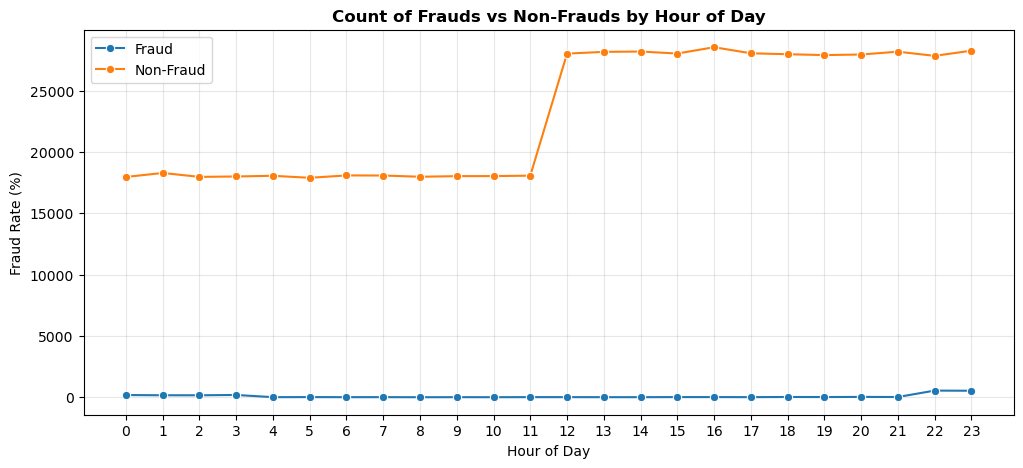

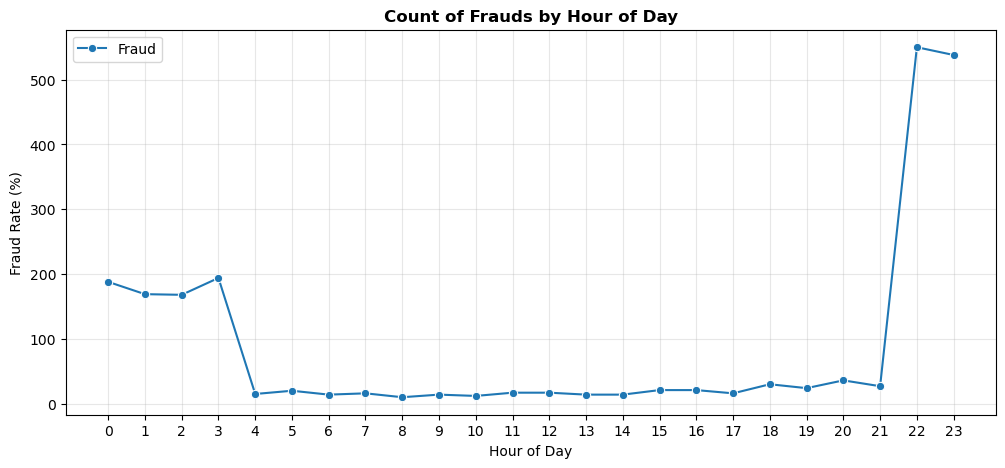

In [42]:
# fraud by hour of day
fraud_by_hour = df_fraud.groupby('trans_time_group').agg({  # group all rows by hour
    'is_fraud': ['sum', 'count']                            #
}).reset_index()
fraud_by_hour.columns = ['hour', 'fraud_count', 'total_count']
fraud_by_hour['non-fraud_count'] = fraud_by_hour['total_count'] - fraud_by_hour['fraud_count']

plt.figure(figsize=(12, 5))
sns.lineplot(data=fraud_by_hour, x='hour', y='fraud_count', marker='o', label = 'Fraud')
sns.lineplot(data=fraud_by_hour, x='hour', y='non-fraud_count', marker='o', label='Non-Fraud')
plt.title('Count of Frauds vs Non-Frauds by Hour of Day', fontsize=12, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=fraud_by_hour, x='hour', y='fraud_count', marker='o', label = 'Fraud')
plt.title('Count of Frauds by Hour of Day', fontsize=12, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate (%)')
plt.xticks(range(0, 24))
plt.grid(alpha=0.3)
plt.show()

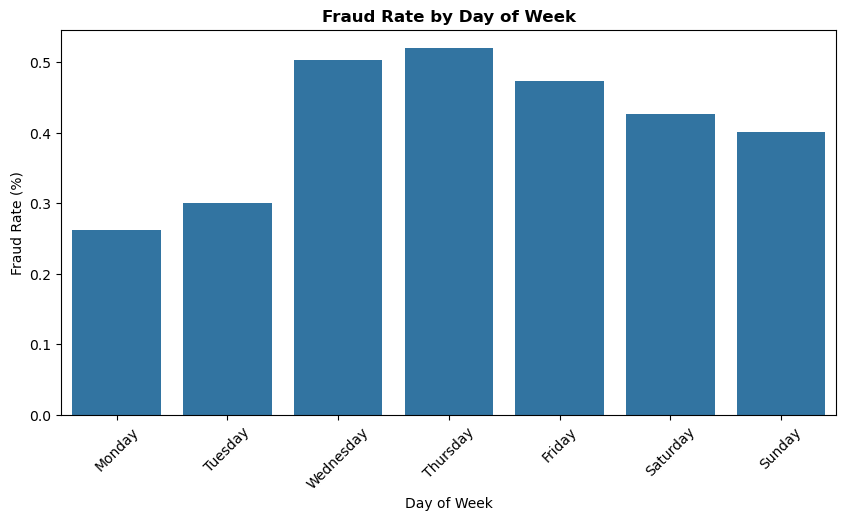

In [43]:
fraud_by_day = df_fraud.groupby('trans_dayOfWeek').agg({
    'is_fraud': ['sum', 'count']
}).reset_index()
fraud_by_day.columns = ['day', 'fraud_count', 'total_count']
fraud_by_day['fraud_rate'] = fraud_by_day['fraud_count'] / fraud_by_day['total_count'] * 100

# Order days properly
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fraud_by_day['day'] = pd.Categorical(fraud_by_day['day'], categories=day_order, ordered=True)
fraud_by_day = fraud_by_day.sort_values('day')

plt.figure(figsize=(10, 5))
sns.barplot(data=fraud_by_day, x='day', y='fraud_rate')
plt.title('Fraud Rate by Day of Week', fontsize=12, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)
plt.show()

Loading ITables v2.5.2 from the internet... (need help?)


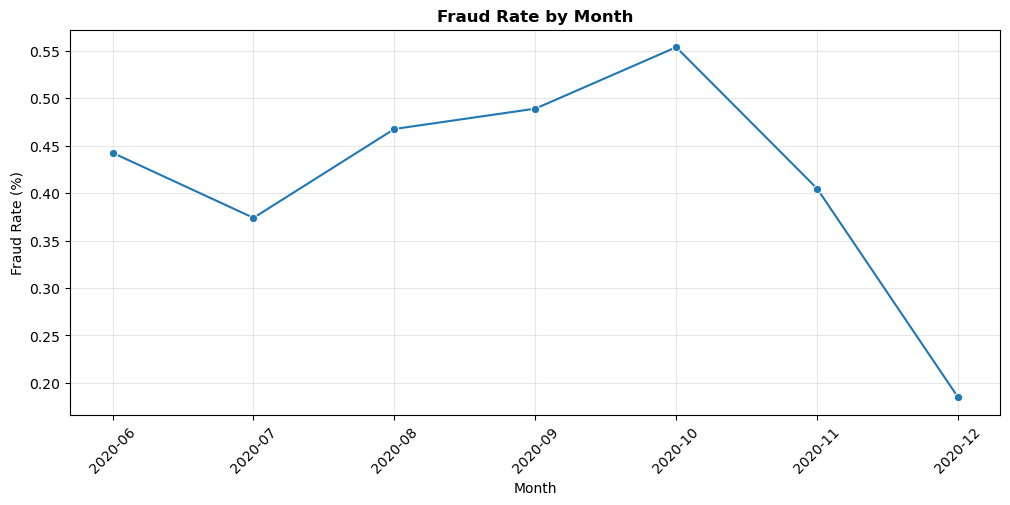

In [46]:
fraud_by_month = df_fraud.groupby('trans_month').agg({
    'is_fraud': ['sum', 'count']
}).reset_index()
fraud_by_month.columns = ['month', 'fraud_count', 'total_count']
fraud_by_month['fraud_rate'] = fraud_by_month['fraud_count'] / fraud_by_month['total_count'] * 100

show(fraud_by_month)

plt.figure(figsize=(12, 5))
sns.lineplot(data=fraud_by_month, x='month', y='fraud_rate', marker='o')
plt.title('Fraud Rate by Month', fontsize=12, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()

### Fraud and merchants

Loading ITables v2.5.2 from the internet... (need help?)


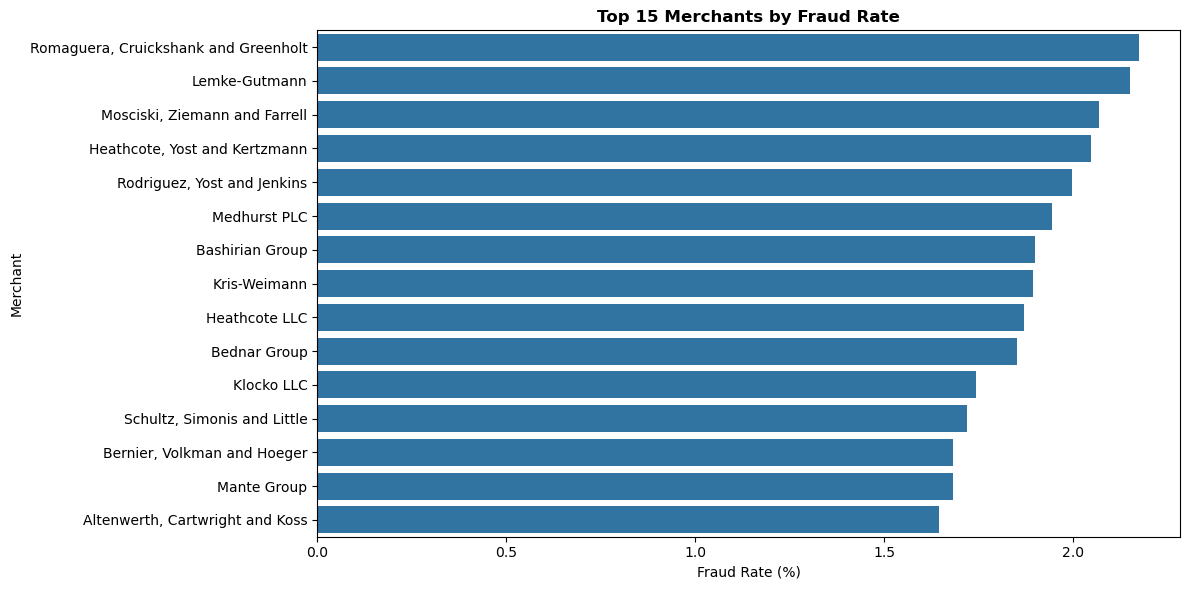

In [ ]:
fraud_by_merchant = df_fraud.groupby('merchant').agg({
    'is_fraud': ['sum', 'count']
}).reset_index()
fraud_by_merchant.columns = ['merchant', 'fraud_count', 'total_count']
fraud_by_merchant['fraud_rate'] = fraud_by_merchant['fraud_count'] / fraud_by_merchant['total_count'] * 100

show(fraud_by_merchant.head())

# plot 15 most fraudulent
top_fraud_rate = fraud_by_merchant.nlargest(15, 'fraud_rate')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_fraud_rate, y='merchant', x='fraud_rate', orient='h')
plt.title('Top 15 Merchants by Fraud Rate', fontsize=12, fontweight='bold')
plt.xlabel('Fraud Rate (%)')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

### Customers

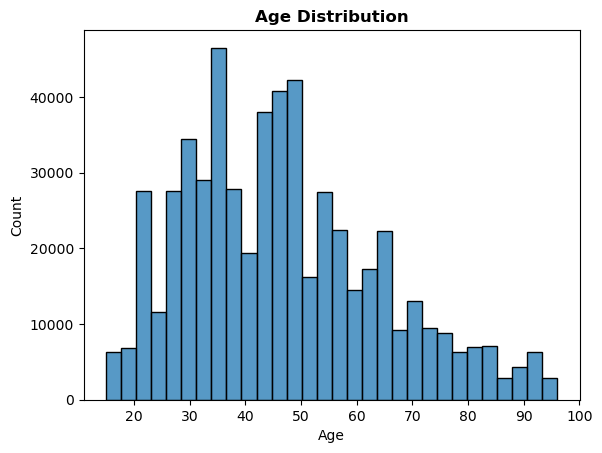

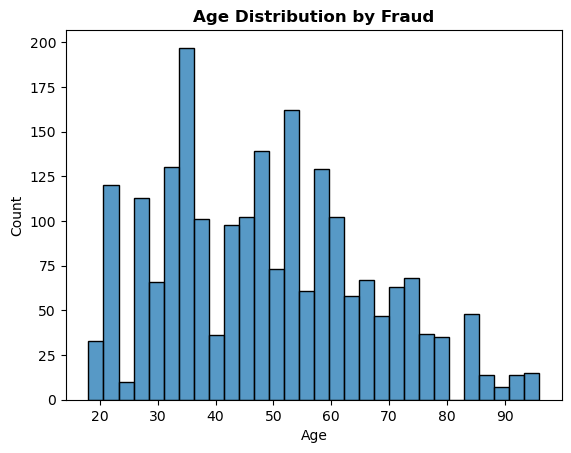

In [61]:
sns.histplot(data=df_fraud, x='age', bins=30)
plt.title('Age Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

sns.histplot(data=df_fraud[df_fraud['is_fraud'] == 1], x='age', bins=30)
plt.title('Age Distribution by Fraud', fontsize=12, fontweight='bold')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

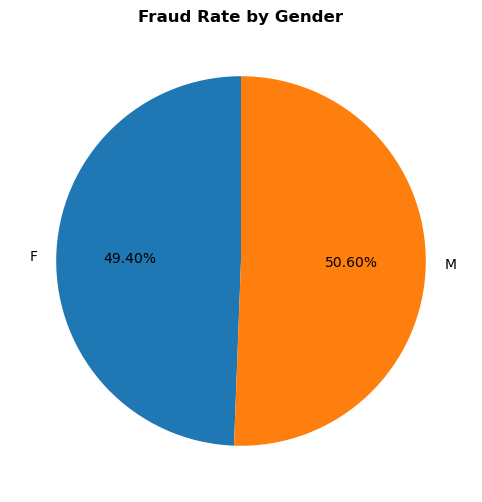

In [62]:
fraud_rate_gender = df_fraud.groupby('gender').agg({
    'is_fraud': ['sum', 'count']
}).reset_index()
fraud_rate_gender.columns = ['gender', 'fraud_count', 'total_count']
fraud_rate_gender['fraud_rate'] = fraud_rate_gender['fraud_count'] / fraud_rate_gender['total_count'] * 100

plt.figure(figsize=(8, 6))
plt.pie(fraud_rate_gender['fraud_rate'], labels=fraud_rate_gender['gender'], autopct='%1.2f%%', startangle=90)
plt.title('Fraud Rate by Gender', fontsize=12, fontweight='bold')
plt.show()